# TASK 4

In [2]:
# Data Loader
import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

def gen_labels(im_name, pat1, pat2):
  '''
  Parameters
  ----------
  im_name : Str
  The image file name.
  pat1 : Str
  A string pattern in the filename for 1st class, e.g "Mel"
  pat2 : Str
  A string pattern in the filename 2nd class, e.g, "Nev"
  Returns
  -------
  Label : Numpy array
  Class label of the filename name based on its pattern.
  '''
  if pat1 in im_name:
    label = np.array([0])
  elif pat2 in im_name:
    label = np.array([1])
  return label

def get_data(data_path, data_list, img_h, img_w):
  """
  Parameters
  ----------
  data_path : Str
  Path to the data directory
  data_list : List
  A list containing the name of the images.
  img_h : Int
  image height to be resized to.
  img_w : Int
  image width to be resized to.
  Returns
  -------
  img_labels : Nested List
  A nested list containing the loaded images along with their
  corresponding labels.
  """
  img_labels = []
  for item in enumerate(data_list):
    img = imread(os.path.join(data_path, item[1]), as_gray = True) # "as_grey"
    img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
    img_labels.append([np.array(img), gen_labels(item[1], 'Mel', 'Nev')])
    if item[0] % 100 == 0:
      print('Reading: {0}/{1} of train images'.format(item[0], len(data_list)))
  
  shuffle(img_labels)
  
  return img_labels

def get_data_arrays(nested_list, img_h, img_w):
  """
  Parameters
  ----------
  nested_list : nested list
    nested list of image arrays with corresponding class labels
  img_h : Int
    image height
  img_w : Int
    image width
  Returns
  -------
  img_arrays : Numpy array
    4D Array with the size of (n_data, img_h, img_w, 1)
  label_arrays : Numpy array
    1D array with the size (n_data).
  """
  img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
  label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
  for ind in range(len(nested_list)):
    img_arrays[ind] = nested_list[ind][0]
    label_arrays[ind] = nested_list[ind][1]
  img_arrays = np.expand_dims(img_arrays, axis =3)
  
  return img_arrays, label_arrays

def get_train_test_arrays(train_data_path, test_data_path, train_list, test_list, img_h, img_w):
  """
  Get the directory to the train and test sets, the files names and
  the size of the image and return the image and label arrays for
  train and test sets.
  """
  train_data = get_data(train_data_path, train_list, img_h, img_w)
  test_data = get_data(test_data_path, test_list, img_h, img_w)
  
  train_img, train_label = get_data_arrays(train_data, img_h, img_w)
  test_img, test_label = get_data_arrays(test_data, img_h, img_w)
  del(train_data)
  del(test_data)
  
  return train_img, test_img, train_label, test_label

img_w, img_h = 128, 128 # Setting the width and heights of the images.
data_path = '/home/group_3/Data/Lab1/Skin/' # Path to data root with two subdirs.
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')
train_list = os.listdir(train_data_path)
test_list = os.listdir(test_data_path)
x_train, x_test, y_train, y_test = get_train_test_arrays(train_data_path, test_data_path, train_list, test_list, img_h, img_w)

Reading: 0/1000 of train images
Reading: 100/1000 of train images
Reading: 200/1000 of train images
Reading: 300/1000 of train images
Reading: 400/1000 of train images
Reading: 500/1000 of train images
Reading: 600/1000 of train images
Reading: 700/1000 of train images
Reading: 800/1000 of train images
Reading: 900/1000 of train images
Reading: 0/200 of train images
Reading: 100/200 of train images


In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD


def MyModel(img_width, img_height, img_ch, base_dense):
  """
  Functional API model.
  name the last layer as "out"; e.g., out = ....
  """
  input_size = (img_width, img_height, img_ch)
  inputs_layer = Input(shape=input_size, name='input_layer')  # input layer
  flatten = Flatten()
  
  dense1 = Dense(base_dense, activation='relu')      # Base layer
  dense2 = Dense(base_dense//2, activation='relu')   # First hidden layer
  dense3 = Dense(base_dense//4, activation='relu')   # Second hidden layer
  dense4 = Dense(1, activation='sigmoid')            # Third hidden layer
  
  x = flatten(inputs_layer)
  x = dense1(x) 
  x = dense2(x) 
  x = dense3(x) 
  out = dense4(x)

  clf = Model(inputs=inputs_layer, outputs=out)
  clf.summary()
  return clf

base_dense = 256
instance_MyModel = MyModel(img_w, img_h, 1, base_dense) 
instance_MyModel.compile(loss='BinaryCrossentropy',
                optimizer = SGD(learning_rate = 0.0001),
                metrics=['binary_accuracy'])
clf_hist = instance_MyModel.fit(x_train, y_train, batch_size=16, epochs=150, verbose=1, validation_data=[x_test,y_test])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,235,777
Trainable params: 4,235,777
Non-train

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-68sxvujz because the default path (/home/group_3/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


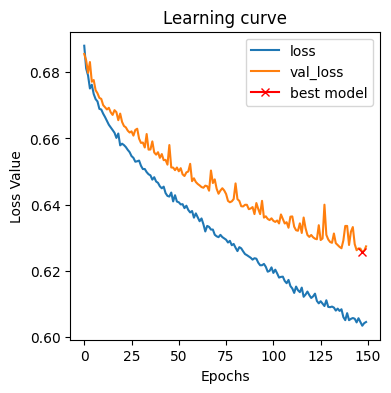

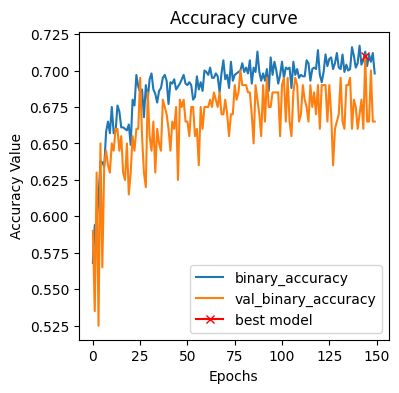

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(clf_hist.history["loss"], label="loss")
plt.plot(clf_hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(clf_hist.history["val_loss"]),
np.min(clf_hist.history["val_loss"]),
marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))
plt.title("Accuracy curve")
plt.plot(clf_hist.history["binary_accuracy"], label="binary_accuracy")
plt.plot(clf_hist.history["val_binary_accuracy"], label="val_binary_accuracy")
plt.plot( np.argmax(clf_hist.history["val_binary_accuracy"]),
np.max(clf_hist.history["val_binary_accuracy"]),
marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Value")
plt.legend()
plt.show()

In [6]:
val_loss = clf_hist.history["val_loss"]
val_accuracy = clf_hist.history["val_binary_accuracy"]
min_loss = np.min(val_loss)
print("--- BEST MODEL ---")
print(f"Validation loss: {min_loss}")

ind_min = val_loss.index(min_loss)
val_acc = val_accuracy[ind_min]
print(f"Validation accuracy: {val_acc}")

--- BEST MODEL ---
Validation loss: 0.6257190704345703
Validation accuracy: 0.699999988079071
